In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist
import random
import sklearn.metrics as metrics

In [2]:
df = pd.read_csv('Player_Attributes.csv')
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [3]:
df.shape

(183978, 42)

# 1. Xử lí dữ liệu:

In [4]:
df.dropna()
names = ['long_shots', 'dribbling', 'ball_control']
for col in names:
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    iqr = q3 - q1 

    lower  = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    df = df[(df[col]>lower) & (df[col]<upper)]
for i in names:
    df[i] = (df[i] - min(df[i])) / (max(df[i]) - min(df[i]))
df.shape

(165508, 42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165508 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   165508 non-null  int64  
 1   player_fifa_api_id   165508 non-null  int64  
 2   player_api_id        165508 non-null  int64  
 3   date                 165508 non-null  object 
 4   overall_rating       165508 non-null  float64
 5   potential            165508 non-null  float64
 6   preferred_foot       165508 non-null  object 
 7   attacking_work_rate  163428 non-null  object 
 8   defensive_work_rate  165508 non-null  object 
 9   crossing             165508 non-null  float64
 10  finishing            165508 non-null  float64
 11  heading_accuracy     165508 non-null  float64
 12  short_passing        165508 non-null  float64
 13  volleys              163833 non-null  float64
 14  dribbling            165508 non-null  float64
 15  curve            

In [6]:
from sklearn.cluster import KMeans 
X = df[names].values

# 2. Tìm số cụm phù hợp

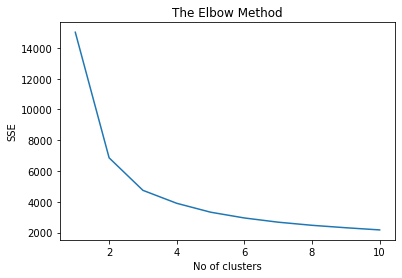

In [7]:
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=5)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('SSE')
plt.show()

# 3. Phân cụm KMeans:

## 3.1. Dùng toán học

In [8]:
def kmeans_init_centroids(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]
def kmeans_assign_labels(X, centroids):
    D = cdist(X, centroids)
    return np.argmin(D, axis = 1)
def has_converged(centroids, new_centroids):
    return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))
def kmeans_update_centroids(X, labels, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids
def kmeans(X, K):
    centroids = [kmeans_init_centroids(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        it += 1
    return (centroids, labels, it)

In [9]:
k=2
centroids, labels, it = kmeans(X, k)
print('Centers found by our algorithm:\n', centroids[-1])

Centers found by our algorithm:
 [[0.40842457 0.39140676 0.34345663]
 [0.66280454 0.66443151 0.60647962]]


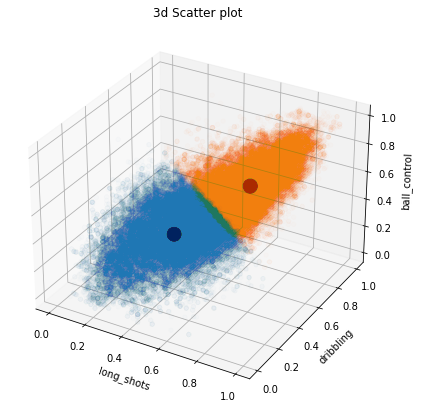

In [10]:
plt.figure(figsize=(15,7))
ax = plt.axes(projection='3d')
for i in range(0,k):
    ax.scatter3D(X[labels[-1]==i, 0], X[labels[-1]==i, 1], X[labels[-1]==i, 2], alpha=0.01)
ax.scatter3D(centroids[-1][:,0], centroids[-1][:,1], centroids[-1][:,2], s = 200, color = 'black', alpha =1)
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])
ax.set_title('3d Scatter plot')
plt.show()

## 3.2. Dùng thư viện sklearn

### Với k = 2: 

In [11]:
model = KMeans(n_clusters = k, random_state=5).fit(X)
print("Center:\n", model.cluster_centers_)
pred_label = model.predict(X)

Center:
 [[0.66299    0.6646106  0.60666623]
 [0.40869516 0.39172907 0.34374464]]


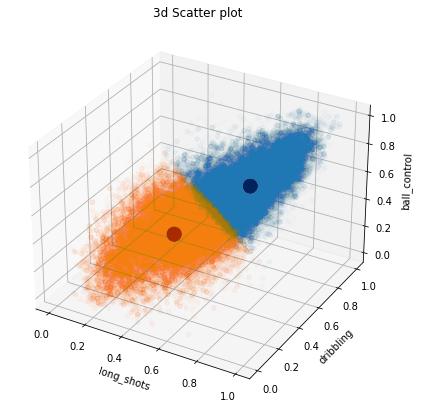

In [12]:
plt.figure(figsize=(15,7))
ax = plt.axes(projection='3d')
for i in range(0,k):
    ax.scatter3D(X[pred_label==i, 0], X[pred_label==i, 1], X[pred_label==i, 2], alpha=0.01)
ax.scatter3D(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2], s = 200, color = 'black', alpha =1)
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])
ax.set_title('3d Scatter plot')
plt.show()

### Với k = 4:

In [13]:
k2 = 4
model2 = KMeans(n_clusters = k2, random_state=5).fit(X)
print("Center:\n", model.cluster_centers_)
pred_label2 = model2.predict(X)

Center:
 [[0.66299    0.6646106  0.60666623]
 [0.40869516 0.39172907 0.34374464]]


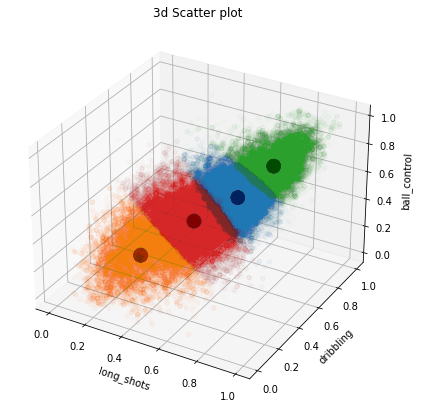

In [14]:
plt.figure(figsize=(15,7))
ax = plt.axes(projection='3d')
for i in range(0,k2):
    ax.scatter3D(X[pred_label2==i, 0], X[pred_label2==i, 1], X[pred_label2==i, 2], alpha=0.01)
ax.scatter3D(model2.cluster_centers_[:,0], model2.cluster_centers_[:,1], model2.cluster_centers_[:,2], s = 200, color = 'black', alpha =1)
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])
ax.set_title('3d Scatter plot')
plt.show()

# 4. Đánh giá mô hình bằng chỉ số Silhouette:

In [15]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
import sklearn.metrics as sm

### Với k = 2:

In [16]:
score = silhouette_score(X, pred_label, metric = 'euclidean')
score

0.45603284256953214

**Nhận xét: Ta có 0 < silhouette_score = 0.456 < 1. Do đó mô hình đang được phân cụm khá chính xác. Các cụm không cách nhau quá xa mà không quá gần**

In [17]:
print('Silhoutte score:', score)

Silhoutte score: 0.45603284256953214


### Với k = 4:

In [18]:
score2 = silhouette_score(X, pred_label2, metric = 'euclidean')
score2

0.30826380939806824

In [19]:
print('Silhoutte score:', score2)

Silhoutte score: 0.30826380939806824
